# Frequency analysis of probe locations

In [7]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from scipy.signal import welch
from stl import mesh
from flowtorch.data import FOAMDataloader, mask_box
from utils import compute_fft

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

run = "/media/andre/Elements/naca0012_shock_buffet/run/"
output = "./output/"
!mkdir -p output

In [8]:
Ma = 0.75
U_inf = 255.22
a_inf = U_inf / Ma
rho_inf = 1.19058
chord = 0.6010500

## Mean and standard deviation of velocity, probe locations, 2D

In [34]:
path = run + "rhoCF_set1_alpha4_saiddes_ref2/"
loader = FOAMDataloader(path)
write_times = loader.write_times[1:]
fields = loader.field_names[write_times[0]]
vertices = loader.vertices
print("Available snapshots: ", len(write_times))
print("Available fields: ", fields)

Available snapshots:  2497
Available fields:  ['alphat', 'Ma', 'nut', 'nuTilda', 'p', 'rho', 'T', 'total(p)_coeff', 'U', 'yPlus']


In [24]:
def add_naca0012_patch(axis, scale=1.0):
    x_up = naca_stl.x[naca_stl.y > 0] * scale
    y_up = naca_stl.y[naca_stl.y > 0] * scale
    x_low = naca_stl.x[naca_stl.y < 0] * scale
    y_low = naca_stl.y[naca_stl.y < 0] * scale
    axis.fill_between(x_up, 0.0, y_up, color="k")
    axis.fill_between(x_low, y_low, 0.0, color="k")
    
naca_stl = mesh.Mesh.from_file("../geometry/naca0012.stl")

In [61]:
vertices /= chord
mask = mask_box(vertices[:, :2], [-1, -1], [3, 1])
n_points = mask.sum().item()

x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)
print("selected points: ", n_points)

selected points:  168508


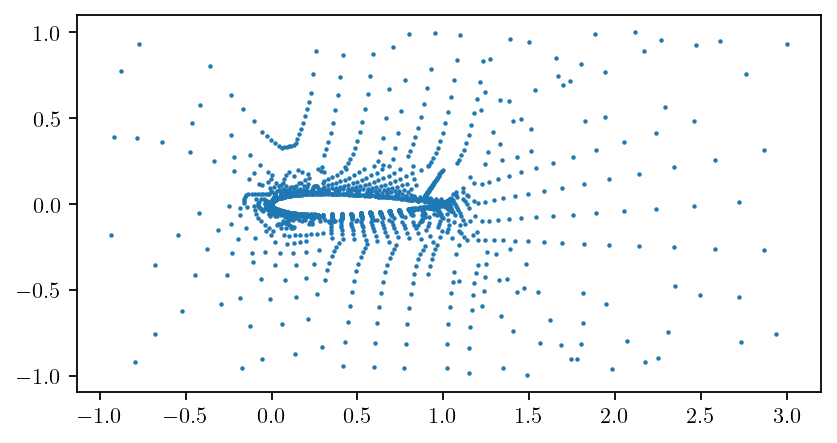

In [62]:
plt.scatter(x[::100], y[::100], s=1)
plt.gca().set_aspect("equal")
plt.show()

In [124]:
time_window = write_times[1596:]
Umag = pt.zeros((n_points, len(time_window)))
for i, time in enumerate(time_window):
    print("\r", f"Processing snapshot {i+1}/{len(time_window)}", end="")
    Umag[:, i] = pt.masked_select(loader.load_snapshot("U", time)[:, :2].norm(dim=1), mask)

 Processing snapshot 901/901Processing snapshot 529/901

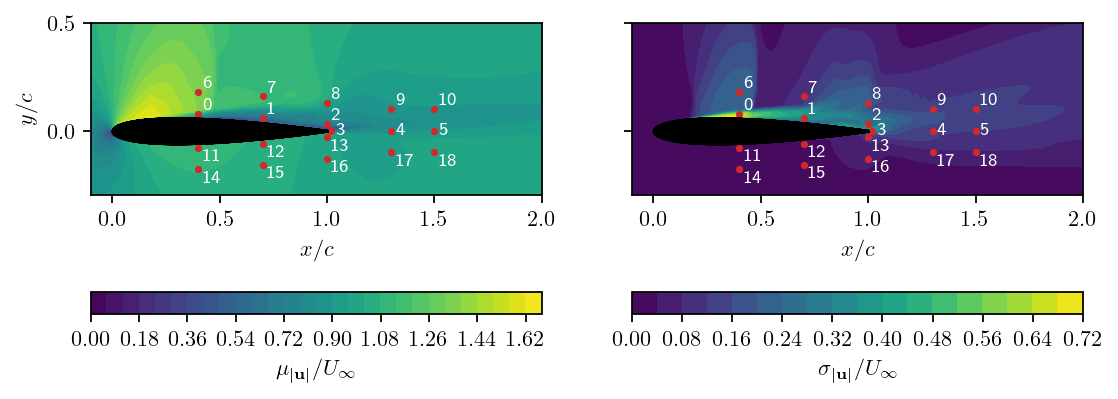

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

dy = 0.1
probes = pt.tensor(
    [
        [0.4, 0.08],
        [0.7, 0.06],
        [1.0, 0.03],
        [1.02, 0.0],
        [1.3, 0.0],
        [1.5, 0.0],
        [0.4, 0.08+dy],
        [0.7, 0.06+dy],
        [1.0, 0.03+dy],
        [1.3, 0.0+dy],
        [1.5, 0.0+dy],
        [0.4, -0.08],
        [0.7, -0.06],
        [1.0, -0.03],
        [0.4, -0.08-dy],
        [0.7, -0.06-dy],
        [1.0, -0.03-dy],
        [1.3, 0.0-dy],
        [1.5, 0.0-dy]
    ]
)

every = 2
cont1 = ax1.tricontourf(x[::every], y[::every], Umag.mean(dim=1)[::every]/U_inf, levels=30)
cont2 = ax2.tricontourf(x[::every], y[::every], Umag.std(dim=1)[::every]/U_inf, levels=20)
plt.colorbar(cont1, ax=ax1, label=r"$\mu_{|\mathbf{u}|}/U_\infty$", orientation="horizontal", pad=0.2)
plt.colorbar(cont2, ax=ax2, label=r"$\sigma_{|\mathbf{u}|}/U_\infty$", orientation="horizontal", pad=0.2)
for ax in (ax1, ax2):
    ax.scatter(probes[:, 0], probes[:, 1], marker="o", c="C3", s=5)
    ax.set_xlabel(r"$x/c$")
    ax.set_aspect("equal")
    ax.set_xlim(-0.1, 2.0)
    ax.set_ylim(-0.3, 0.5)
    add_naca0012_patch(ax)
    for p in range(probes.shape[0]):
        dy = 0.0 if probes[p, 1] == 0.0 else 0.04
        dy = dy if probes[p, 1] > 0.0 else -dy
        ax.text(probes[p, 0]+0.02, probes[p, 1]+dy, s=f"{p}", fontsize=8, c="w", va="center")
ax1.set_ylabel(r"$y/c$")
plt.show()

In [173]:
freq, amp = [], []
vertices_masked = pt.stack((x, y), dim=1)
times_num = np.array([float(t) for t in time_window])
for p in range(probes.shape[0]):
    closest = (vertices_masked - probes[p]).norm(dim=1).argmin()
    Up = Umag[closest]
    f, a = compute_fft(times_num, (Up-Up.mean()).numpy(), 0.0, 0.25)
    freq.append(np.copy(f))
    amp.append(np.copy(a))

Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.1111Hz; f_max=5005.56Hz
Selected 901 samples; frequency resolution df=11.11

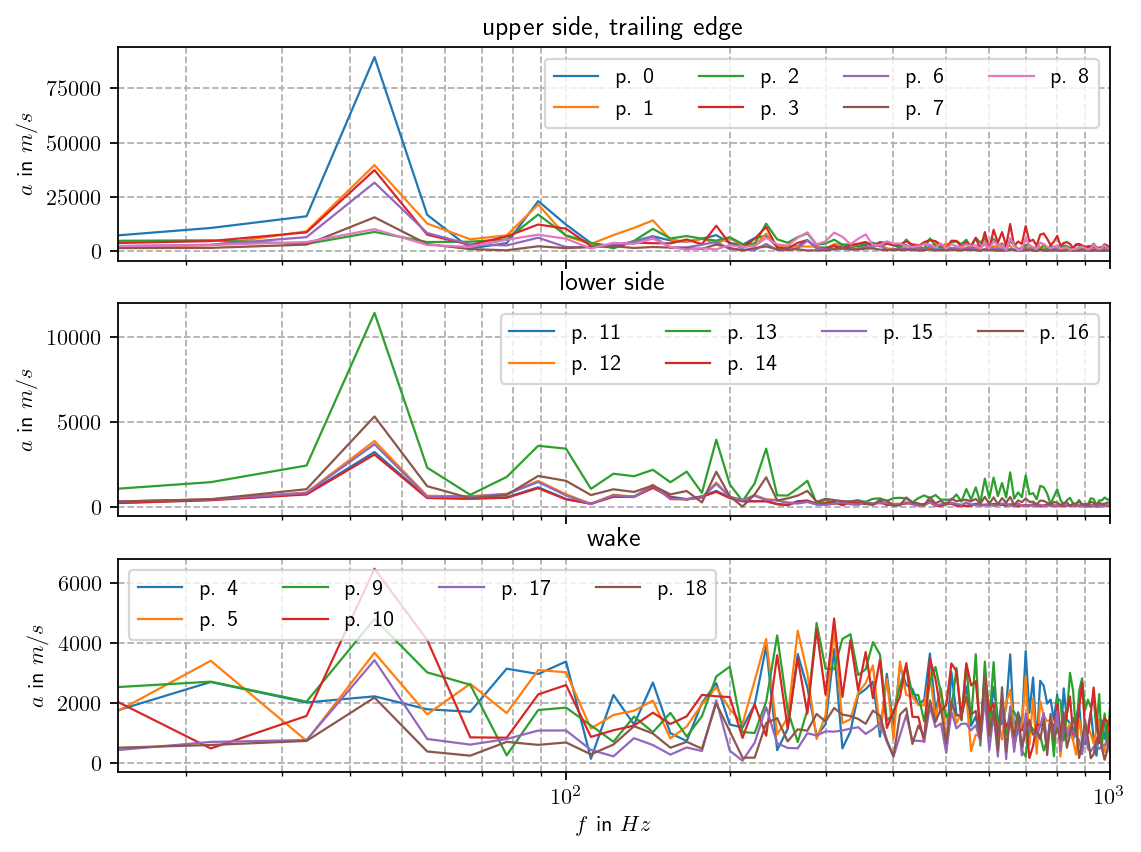

In [174]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

for p in [0, 1, 2, 3, 6, 7, 8]:
    ax1.plot(freq[p], amp[p], lw=1, label=f"p. {p}")
    
for p in [11, 12, 13, 14, 15, 16]:
    ax2.plot(freq[p], amp[p], lw=1, label=f"p. {p}")
    
for p in [4, 5, 9, 10, 17, 18]:
    ax3.plot(freq[p], amp[p], lw=1, label=f"p. {p}")

for ax in (ax1, ax2, ax3):
    ax.set_xscale("log")
    ax.set_xlim(15, 1000)
    ax.legend(ncol=4)
    ax.grid(which="both", ls="--")
    ax.set_ylabel(r"$a$ in $m/s$")

ax3.set_xlabel(r"$f$ in $Hz$")
ax1.set_title("upper side, trailing edge")
ax2.set_title("lower side")
ax3.set_title("wake")
plt.show()

## Mean and standard deviation of velocity, probe locations, 3D

In [9]:
path = run + "rhoCF_set1_alpha4_saiddes_ref0_z25/"
loader = FOAMDataloader(path)
write_times = loader.write_times[1:]
fields = loader.field_names[write_times[0]]
loader._case._distributed = False
vertices = loader.vertices
volumes = loader.weights
print("Available snapshots: ", len(write_times))
print("Available fields: ", fields)

Loading precomputed cell centers and volumes from constant/
Available snapshots:  1588
Available fields:  ['alphat', 'Ma', 'nut', 'nuTilda', 'p', 'rho', 'T', 'total(p)_coeff', 'U', 'yPlus']


In [10]:
vertices /= chord
# pick a slice from the middle spanwise position
mask = mask_box(vertices, [-1, -1, 0.0024042/chord], [3, 1, 0.0072126/chord])
n_points = mask.sum().item()

x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)
weights = pt.masked_select(volumes, mask)
print("selected points: ", n_points)

selected points:  79706


In [11]:
#ax.axvline(0.0325)
#ax.axvline(0.101)
write_times[322], write_times[1011]

('0.0326', '0.1015')

In [12]:
time_window = write_times[321:998]
U = pt.zeros((n_points, 3, len(time_window)))
for i, time in enumerate(time_window):
    print("\r", f"Processing snapshot {i+1}/{len(time_window)}", end="")
    Utemp = loader.load_snapshot("U", time)
    U[:, 0, i] = pt.masked_select(Utemp[:, 0], mask)
    U[:, 1, i] = pt.masked_select(Utemp[:, 1], mask)
    U[:, 2, i] = pt.masked_select(Utemp[:, 2], mask)

 Processing snapshot 677/677

In [13]:
pt.save(x, f'{output}x_masked_3D_ref0_lecture.pt')
pt.save(y, f'{output}y_masked_3D_ref0_lecture.pt')
pt.save(weights, f'{output}vol_masked_3D_ref0_lecture.pt')
pt.save(U, f'{output}U_masked_3D_ref0_lecture.pt')

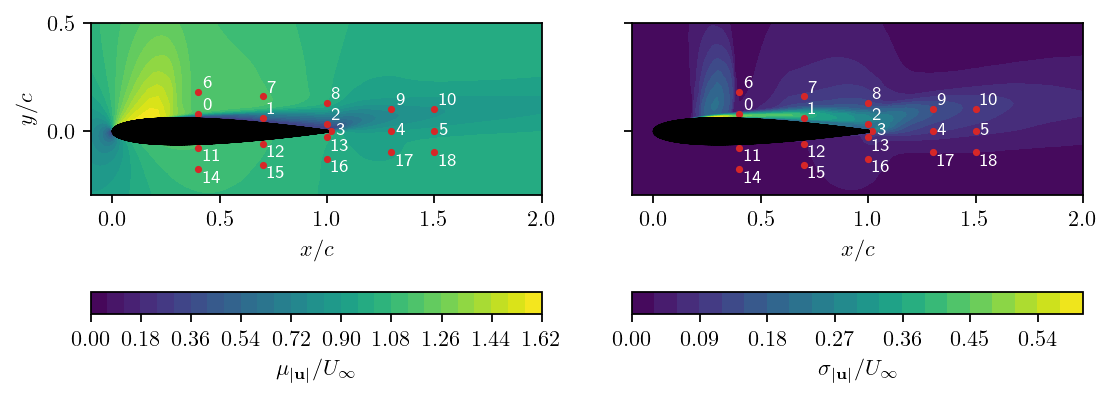

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

dy = 0.1
probes = pt.tensor(
    [
        [0.4, 0.08],
        [0.7, 0.06],
        [1.0, 0.03],
        [1.02, 0.0],
        [1.3, 0.0],
        [1.5, 0.0],
        [0.4, 0.08+dy],
        [0.7, 0.06+dy],
        [1.0, 0.03+dy],
        [1.3, 0.0+dy],
        [1.5, 0.0+dy],
        [0.4, -0.08],
        [0.7, -0.06],
        [1.0, -0.03],
        [0.4, -0.08-dy],
        [0.7, -0.06-dy],
        [1.0, -0.03-dy],
        [1.3, 0.0-dy],
        [1.5, 0.0-dy]
    ]
)

every = 2
cont1 = ax1.tricontourf(x[::every], y[::every], Umag.mean(dim=1)[::every]/U_inf, levels=30)
cont2 = ax2.tricontourf(x[::every], y[::every], Umag.std(dim=1)[::every]/U_inf, levels=20)
plt.colorbar(cont1, ax=ax1, label=r"$\mu_{|\mathbf{u}|}/U_\infty$", orientation="horizontal", pad=0.2)
plt.colorbar(cont2, ax=ax2, label=r"$\sigma_{|\mathbf{u}|}/U_\infty$", orientation="horizontal", pad=0.2)
for ax in (ax1, ax2):
    ax.scatter(probes[:, 0], probes[:, 1], marker="o", c="C3", s=5)
    ax.set_xlabel(r"$x/c$")
    ax.set_aspect("equal")
    ax.set_xlim(-0.1, 2.0)
    ax.set_ylim(-0.3, 0.5)
    add_naca0012_patch(ax)
    for p in range(probes.shape[0]):
        dy = 0.0 if probes[p, 1] == 0.0 else 0.04
        dy = dy if probes[p, 1] > 0.0 else -dy
        ax.text(probes[p, 0]+0.02, probes[p, 1]+dy, s=f"{p}", fontsize=8, c="w", va="center")
ax1.set_ylabel(r"$y/c$")
plt.show()

In [39]:
freq, amp = [], []
vertices_masked = pt.stack((x, y), dim=1)
times_num = np.array([float(t) for t in time_window])
for p in range(probes.shape[0]):
    closest = (vertices_masked - probes[p]).norm(dim=1).argmin()
    Up = Umag[closest]
    #f, a = compute_fft(times_num, (Up-Up.mean()).numpy(), 0.0, 0.25)
    fs = Up.shape[0] / (times_num[-1]-times_num[0])
    f, a = welch(Up-Up.mean(), fs=fs, nperseg=225, detrend="linear", nfft=2*225)
    freq.append(np.copy(f))
    amp.append(np.copy(a))

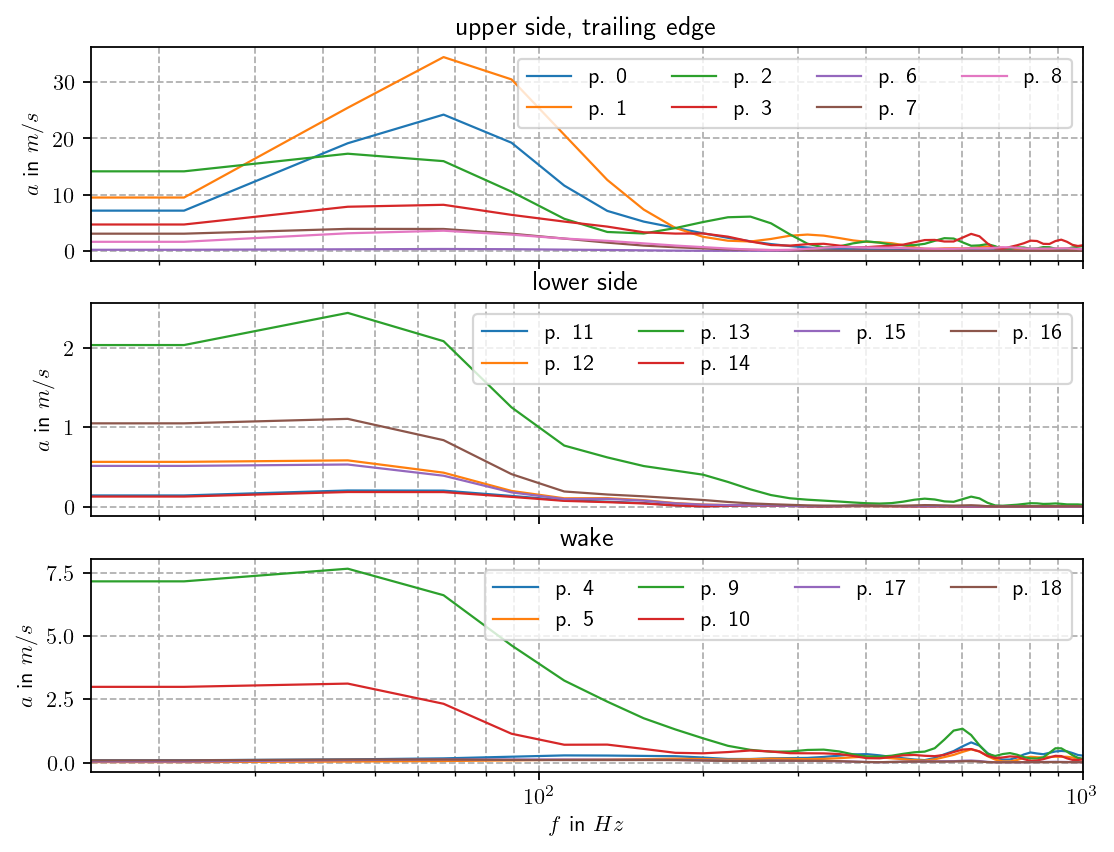

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

for p in [0, 1, 2, 3, 6, 7, 8]:
    ax1.plot(freq[p], amp[p], lw=1, label=f"p. {p}")
    
for p in [11, 12, 13, 14, 15, 16]:
    ax2.plot(freq[p], amp[p], lw=1, label=f"p. {p}")
    
for p in [4, 5, 9, 10, 17, 18]:
    ax3.plot(freq[p], amp[p], lw=1, label=f"p. {p}")

for ax in (ax1, ax2, ax3):
    ax.set_xscale("log")
    ax.set_xlim(15, 1000)
    ax.legend(ncol=4)
    ax.grid(which="both", ls="--")
    ax.set_ylabel(r"$a$ in $m/s$")

ax3.set_xlabel(r"$f$ in $Hz$")
ax1.set_title("upper side, trailing edge")
ax2.set_title("lower side")
ax3.set_title("wake")
plt.show()